### Predicting Customer Churn
This notebook performs these steps:<br/>
1. Builds a scikit-learn model to predict customer churn
2. Stores the model into the project
3. Stores the model into the deployment space
4. Creates and test an Online Deployement for the model
5. Creates and test a Batch Deployment for the model

### Environment Setup

In [1]:
!pip install sklearn-pandas
# Update WML library
!pip install -U ibm-watson-machine-learning

     |████████████████████████████████| 41.6 MB 19.4 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 1.7 MB 21.0 MB/s eta 0:00:01
  Attempting uninstall: ibm-watson-machine-learning
    Found existing installation: ibm-watson-machine-learning 1.0.141
    Uninstalling ibm-watson-machine-learning-1.0.141:
      Successfully uninstalled ibm-watson-machine-learning-1.0.141


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import json, requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


### Step 1: Load data 
Insert <b><font color=blue>your own</font></b> values for the <b>ibm_api_key_id</b> and <b>bucket name</b> in the appropriate places of the two cells below  

In [3]:
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

import pandas as pd

customer_churn = pd.read_csv(wslib.mount.get_data_path('churn.csv'))
customer_churn.head()

ID CHURN
0   6     F
1  11     F
2  22     F
3  23     F
4  35     T

In [4]:
customer = pd.read_csv('/project_data/data_asset/customer-profile.csv')
customer.head()

ID Gender Status  Children  Est Income Car Owner        Age  \
0  11      M      S       2.0       96.33         N  56.473333   
1  14      F      M       2.0    52004.80         N  25.140000   
2  22      M      S       1.0    57626.90         Y  43.906667   
3  23      M      M       2.0    20078.00         N  32.846667   
4  35      F      S       0.0    78851.30         N  48.373333   

   AvgMonthlySpend  CustomerSupportCalls Paymethod  MembershipPlan  
0            32.88                   1.0        CC             1.0  
1            23.11                   0.0        CH             1.0  
2            38.96                   0.0        CC             2.0  
3             6.33                   0.0        CC             4.0  
4            28.66                   0.0        CC             4.0

### Step 2: Merge Files

In [5]:
data = pd.merge(customer, customer_churn, on='ID')

### Step 3: Rename some columns
This step is to remove spaces from columns names, it's an example of data preparation that you may want to do before creating a model. 

In [6]:
data.columns

Index(['ID', 'Gender', 'Status', 'Children', 'Est Income', 'Car Owner', 'Age',
       'AvgMonthlySpend', 'CustomerSupportCalls', 'Paymethod',
       'MembershipPlan', 'CHURN'],
      dtype='object')

In [7]:
data.rename(columns={'Est Income':'EstIncome', 'Car Owner':'CarOwner' }, inplace=True)

In [8]:
data.head()

ID Gender Status  Children  EstIncome CarOwner        Age  AvgMonthlySpend  \
0  11      M      S       2.0      96.33        N  56.473333            32.88   
1  22      M      S       1.0   57626.90        Y  43.906667            38.96   
2  23      M      M       2.0   20078.00        N  32.846667             6.33   
3  35      F      S       0.0   78851.30        N  48.373333            28.66   
4  36      F      S       1.0   17540.70        Y  62.786667            13.45   

   CustomerSupportCalls Paymethod  MembershipPlan CHURN  
0                   1.0        CC             1.0     F  
1                   0.0        CC             2.0     F  
2                   0.0        CC             4.0     F  
3                   0.0        CC             4.0     T  
4                   0.0      Auto             4.0     T

In [9]:
data.shape

(785, 12)

In [10]:
# Uncomment if you would like to see the profile report

#Uncomment and run once to install the package in your runtime environment
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [11]:
# Uncomment if you would like to see the profile report
#from pandas_profiling import ProfileReport
    
#profile = ProfileReport(data, title="Data Profiling Report")
#profile.to_widgets()

### Step 4: Data understanding

In [12]:
data.describe()

ID    Children      EstIncome         Age  AvgMonthlySpend  \
count   785.000000  785.000000     785.000000  785.000000       785.000000   
mean   1962.872611    1.131210   49411.709108   42.062616        59.886841   
std    1090.896925    0.831066   30976.276910   15.226786        57.342251   
min      11.000000    0.000000      96.330000   12.326667         0.790000   
25%    1046.000000    0.000000   19749.300000   27.746667        14.380000   
50%    1982.000000    1.000000   49910.700000   45.360000        39.620000   
75%    2871.000000    2.000000   76161.400000   54.013333        87.880000   
max    3824.000000    2.000000  120000.000000   77.000000       332.460000   

       CustomerSupportCalls  MembershipPlan  
count            785.000000      785.000000  
mean               0.114650        2.508280  
std                0.456922        1.157383  
min                0.000000        1.000000  
25%                0.000000        1.000000  
50%                0.000000        2.000000  
75%                0.000000        4.000000  
max                4.000000        4.000000

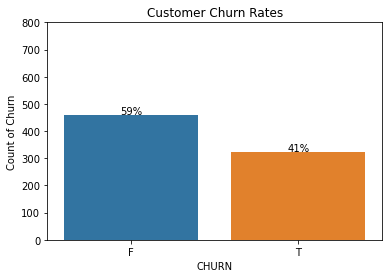

In [13]:
g1 = sns.countplot(data=data, x='CHURN', order=data.CHURN.value_counts().index)
plt.title('Customer Churn Rates')
plt.ylabel('Count of Churn')
plt.ylim(0, 800)
#Add percentages to the graph
total = float(len(data)) #one person per row
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{0:.0%}'.format(height/total),
            ha="center") 
plt.show()

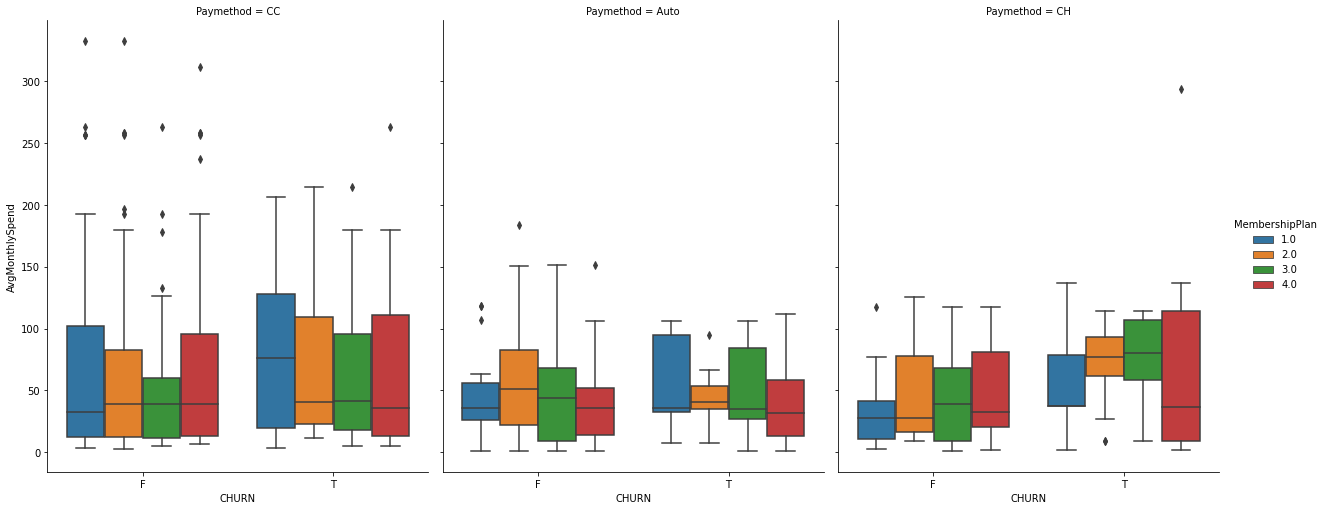

In [14]:
sns.catplot(x="CHURN", y="AvgMonthlySpend",
                 hue="MembershipPlan", col="Paymethod",
                 data=data, kind='box',
                 height=7, aspect=.81);

### Step 5: Build the sklearn pipeline and the Random Forest model


In [15]:
# Define input data to the model
X = data.drop(['ID','CHURN'], axis=1)

In [16]:
# Define the target variable and encode with value between 0 and n_classes-1, that is from T/F to 1/0
le = LabelEncoder()
y = le.fit_transform(data['CHURN'])

In [17]:
label_mapping=le.inverse_transform([0,1])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])

0:  F
1:  T


In [18]:
# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

#### Use the DataFrameMapper class to declare transformations and variable imputations.

* LabelBinarizer - Converts a categorical variable into a dummy variable (aka binary variable)
* StandardScaler - Standardize features by removing the mean and scaling to unit variance, z = (x - u) / s

See docs: 
* https://github.com/scikit-learn-contrib/sklearn-pandas
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer
* https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [19]:

mapper_good = DataFrameMapper([
    (['Gender'], LabelBinarizer()),
    (['Status'], LabelBinarizer()),
    (['CarOwner'], LabelBinarizer()),
    (['Paymethod'], LabelBinarizer()),
    (['MembershipPlan'], LabelBinarizer()),
    (['Children'],  StandardScaler()),
    (['EstIncome'],  StandardScaler()),
    (['Age'],  StandardScaler()),
    (['AvgMonthlySpend'],  StandardScaler()),
    (['CustomerSupportCalls'],  StandardScaler())], default=False)


In [20]:
# Instantiate the Classifier
random_forest = RandomForestClassifier(random_state=5)

# Define the steps in the pipeline to sequentially apply a list of transforms and the estimator, i.e. RandomForestClassifier
steps = [('mapper', mapper_good),('RandonForestClassifier', random_forest)]
pipeline = sklearn.pipeline.Pipeline(steps)

# train the model
model=pipeline.fit( X_train, y_train )

model

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Gender'], LabelBinarizer()),
                                           (['Status'], LabelBinarizer()),
                                           (['CarOwner'], LabelBinarizer()),
                                           (['Paymethod'], LabelBinarizer()),
                                           (['MembershipPlan'],
                                            LabelBinarizer()),
                                           (['Children'], StandardScaler()),
                                           (['EstIncome'], StandardScaler()),
                                           (['Age'], StandardScaler()),
                                           (['AvgMonthlySpend'],
                                            StandardScaler()),
                                           (['CustomerSupportCalls'],
                                            StandardScaler())])),
   

In [21]:
# Display Label Mapping to assist with interpretation of the model
label_mapping=le.inverse_transform([0,1])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])

0:  F
1:  T


In [22]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )

### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )

### and print the report
print(report)

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       127
           1       0.74      0.64      0.69       109

    accuracy                           0.73       236
   macro avg       0.74      0.73      0.73       236
weighted avg       0.73      0.73      0.73       236



###  Step 6:  Tune the model to find the best model

In [23]:
# List keys to the model param to tune
#model.get_params().keys()

In [24]:
parameters = { 'RandonForestClassifier__max_depth': [5,8,10],
               'RandonForestClassifier__n_estimators': [150,180,200]}

In [25]:
grid_obj = GridSearchCV(estimator=model, param_grid=parameters,  cv=3)

In [26]:
# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)


In [27]:
# Get the estimator
best_clf = grid_fit.best_estimator_

In [28]:
best_predictions = best_clf.predict(X_test)

In [29]:
best_predictions_report = sklearn.metrics.classification_report( y_test, best_predictions )

In [30]:
print('Results of best fitted model: \n\n',best_predictions_report)

Results of best fitted model: 

               precision    recall  f1-score   support

           0       0.74      0.83      0.78       127
           1       0.77      0.65      0.71       109

    accuracy                           0.75       236
   macro avg       0.75      0.74      0.74       236
weighted avg       0.75      0.75      0.75       236



In [31]:
print('Results of default model: \n\n',report)

Results of default model: 

               precision    recall  f1-score   support

           0       0.73      0.81      0.77       127
           1       0.74      0.64      0.69       109

    accuracy                           0.73       236
   macro avg       0.74      0.73      0.73       236
weighted avg       0.73      0.73      0.73       236



In [32]:
m_step=pipeline.named_steps['mapper']

In [33]:
m_step.transformed_names_

['Gender',
 'Status_D',
 'Status_M',
 'Status_S',
 'CarOwner',
 'Paymethod_Auto',
 'Paymethod_CC',
 'Paymethod_CH',
 'MembershipPlan_1.0',
 'MembershipPlan_2.0',
 'MembershipPlan_3.0',
 'MembershipPlan_4.0',
 'Children',
 'EstIncome',
 'Age',
 'AvgMonthlySpend',
 'CustomerSupportCalls']

In [34]:
features = m_step.transformed_names_

In [35]:
# Get the features importance
importances = pipeline.named_steps['RandonForestClassifier'][1].feature_importances_
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

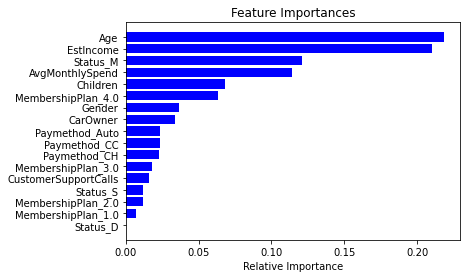

In [36]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), (np.array(features))[indices])
plt.xlabel('Relative Importance')

### Step 7: Save Model in the WML Deployment Space


<div class="alert alert-block alert-info">
You have a choice to either save the model in the <b>project</b> OR the <b>deployment space</b>:<br><br>
    <li> If you're saving your model in your project, you have to set the default project using the python client.</li><br>
    <li>If you're saving the model in the deployment space, first, we will check if an existing deployment space is already associated with this project and set the associated deployment space as the default space.  If this project is not yet associated with a deployment space, we will create a deployment space.. From there you'll be able to deploy and score the model in your deployment space.</li></div>


In [37]:
# get the Project ID and set the location to save the model to the project
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "4.0"
}

client = APIClient(wml_credentials)

project_id = os.environ['PROJECT_ID']
client.set.default_project(project_id)

Python 3.7 and 3.8 frameworks are deprecated and will be removed in a future release. Use Python 3.9 framework instead.


'SUCCESS'

In [38]:
# Note - this step is commented out because we are saving to a Deployment Space. If you would like to save to the project instead, comment out the code. 
# The "pc" object is generated by "Insert project token" action from the top menu. Make sure to insert the code and run it if you want to save to the project. 
# client.set.default_project(pc.project_id)

# IMPORTANT
# Replace the space_uid value with the Space ID that you looked up on the Settings tab of your Deployment Space
space_uid='0eaef2ee-dd8a-4292-8c2d-3edcdc0da0d0'

# Set default project and space. When we invoke the store_model function in the next cell, it will save the model to the specified project and space
client.set.default_space(space_uid)

Unsetting the project_id ...


'SUCCESS'

In [39]:
# Provide metadata and save the model into the repository. After running this cell, the model will be displayed in the Assets view

# Model Metadata

model_name = 'customer_churn_model_2'
software_spec_uid = client.software_specifications.get_uid_by_name('default_py3.7_opence')

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23"
}

stored_model_details = client.repository.store_model(pipeline,
                                               meta_props=metadata,
                                               training_data=X_train,
                                               training_target=y_train)

You can choose to stop here, navigate to the project and promote/deploy the saved model into the deployment space using the UI, or continue executing the code cells belows to deploy the model programmatically.

### Step 8: Create an Online Deployment for the stored model

In [41]:
model_uid = client.repository.get_model_uid(stored_model_details)
deployment = client.deployments.create(
    artifact_uid=model_uid,
    meta_props={
        client.deployments.ConfigurationMetaNames.NAME: "Churn Deployment via API-Online",
        client.deployments.ConfigurationMetaNames.ONLINE:{}}
)

This method is deprecated, please use get_model_id()


#######################################################################################

Synchronous deployment creation for uid: 'a478d2b8-97bf-4b3e-b7a8-501e38f4ab8f' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='05f699c8-16f0-4854-836a-d0cfd7790ffb'
------------------------------------------------------------------------------------------------




### Step 8. Test the Online Deployment By Sending a Score Request (with data) to the Scoring Endpoint

In [42]:
deployment_id = client.deployments.get_id(deployment)

In [43]:
scoring_data = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [
        {
            'fields': ['Gender', 'Status', 'Children', 'EstIncome', 'CarOwner', 'Age', 'AvgMonthlySpend', 'CustomerSupportCalls', 'Paymethod', 'MembershipPlan'],
            'values': [['M','S',2.0,25000,'Y',25,10,1,'CC',1]]
        }]
}

predictions = client.deployments.score(deployment_id, scoring_data)
print(predictions)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[0, [0.5953333333333333, 0.4046666666666667]]]}]}


In [44]:
# get the predicted value and reverse the label transformation
predicted_value = predictions.get('predictions')[0].get('values')[0][0]
le.inverse_transform([predicted_value])

array(['F'], dtype=object)

### Step 9: Create a Batch Deployment for the stored model

In [46]:
# Choose a Deployment Name & Tag for the BATCH Deployment

deployment_name = "Churn Deployment via API-Batch"
deployment_desc = 'Churn Model deployed for Batch scoring using a small configuration'

In [47]:
# Create the deployment metadata and then create the BATCH deployment

# Create the metedata
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.DESCRIPTION: deployment_desc,
    client.deployments.ConfigurationMetaNames.BATCH: {},
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC:{
         "name": "XS",       # XS, S, M, L, XL
         "nodes": 2
     }
}

# Create the deployment
#model_uid = published_model_details["metadata"]["id"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'a478d2b8-97bf-4b3e-b7a8-501e38f4ab8f' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='b7661d30-8008-4993-bfdb-e793c40cd205'
------------------------------------------------------------------------------------------------




### Step 10: Create a Job to run the Batch Deployment

#### Obtain the BATCH Deployment UID

In [49]:
deployment_details

{'entity': {'asset': {'id': 'a478d2b8-97bf-4b3e-b7a8-501e38f4ab8f'},
  'batch': {},
  'custom': {},
  'deployed_asset_type': 'model',
  'description': 'Churn Model deployed for Batch scoring using a small configuration',
  'hardware_spec': {'id': 'f3ebac7d-0a75-410c-8b48-a931428cc4c5',
   'name': 'XS',
   'num_nodes': 1},
  'name': 'Churn Deployment via API-Batch',
  'space_id': '0eaef2ee-dd8a-4292-8c2d-3edcdc0da0d0',
  'status': {'state': 'ready'}},
 'metadata': {'created_at': '2022-04-13T19:23:19.080Z',
  'description': 'Churn Model deployed for Batch scoring using a small configuration',
  'id': 'b7661d30-8008-4993-bfdb-e793c40cd205',
  'modified_at': '2022-04-13T19:23:19.080Z',
  'name': 'Churn Deployment via API-Batch',
  'owner': '1000331005',
  'space_id': '0eaef2ee-dd8a-4292-8c2d-3edcdc0da0d0'}}

In [51]:
# Obtain the BATCH Deployment UID from the batch deployment details - the job needs to be linked to the batch deployment it is going to run

batch_deployment_uid = deployment_details["metadata"]["id"]
batch_deployment_uid

'b7661d30-8008-4993-bfdb-e793c40cd205'

#### Obtain the Data Asset Information Required to Create the Job

<font color = blue>This examples assumes that the input file for batch scoring "new_customers.csv" is already in the deployment space.<br>
Whilst files/data connections can be promoted to the deployment space using APIs, this file was manually promoted to the deployment space for the GUI based deployment earlier in the lab.</font>

In [52]:
client.data_assets.list()

-------------------------------------  ----------  -----  ------------------------------------
NAME                                   ASSET_TYPE  SIZE   ASSET_ID
new_customers.csv                      data_asset  86852  9d75e401-966d-4755-b7b2-b407032b344c
Churn_Scoring_April_12.csv             data_asset  8488   76ef226b-ec9e-4574-9fb8-c248caa35374
Churn_Scoring_April_12.csv             data_asset  8488   cf4940df-7264-414b-967a-2669e79972a4
flow_customer_churn_batch_scoring.csv  data_asset  3773   a1d0290b-3316-4e3d-934a-c75a32da1dc2
-------------------------------------  ----------  -----  ------------------------------------


In [55]:
#copy the data file name and asset id from the output in the previous cell to the commands below:
input_file = 'new_customers.csv'                     #update this filename if you are not using the default file promoted in the last section of the lab
asset_id = '9d75e401-966d-4755-b7b2-b407032b344c'

In [56]:
data_asset = client.data_assets.get_details(asset_id)
input_data_href = client.data_assets.get_href(data_asset)
print('Input Data HREF is: ' + str(input_data_href))


Input Data HREF is: /v2/assets/9d75e401-966d-4755-b7b2-b407032b344c?space_id=0eaef2ee-dd8a-4292-8c2d-3edcdc0da0d0


#### Create the JOB Payload metadata

In [57]:
# Specify the name and description of the CSV file which will contain the results of the scoring process
batch_output_file = "Churn Results - Batch API.csv"
batch_output_desc = "Data file containing the scoring results of the churn model processed via API"

In [58]:
# Specify the input


job_payload_ref = {
    client.deployments.ScoringMetaNames.INPUT_DATA_REFERENCES: [{
        "name": input_file,
        "type": "data_asset",
        "connection": {},
        "location": {
                      "href":  input_data_href
                    }
    }],
    client.deployments.ScoringMetaNames.OUTPUT_DATA_REFERENCE: {       
            "type": "data_asset",
            "connection": {},
            "location": {
                "name": batch_output_file,
                "description": batch_output_desc
            }
        }
}

#### Create the JOB
<font color=blue><b>Note:</b> The JOB automatically executes upon creation</font><br><br>


In [59]:
# Create the job

job = client.deployments.create_job(deployment_id=batch_deployment_uid,meta_props=job_payload_ref)

#### Check to see if the job has successfully completed

In [60]:
#Find the job ID

job_id = client.deployments.get_job_uid(job)
print(job_id)

7d7792d7-f49b-4be6-bbc8-294571a53ebc


In [61]:
#Find the status of the job which has just been created and executed
client.deployments.get_job_status(job_id)

{'completed_at': '', 'running_at': '', 'state': 'queued'}

**Author:**  Sidney Phoon and Elena Lowery <br/>
**Date:**  September 2021